# COMP3222/6246 Machine Learning Technologies (2019/20)
# Lab 5 – Perceptrons, Deep Net, and Convolutional Neural Net

In this lab, we introduce how to implement a perceptron, a deep neural network and also a convolutional neural network (DNN). Though it is not a good practise, we use all the data to train and test our model for the purpose of demonstration. We also present you with a code that is working, but yields poor results. We expect you to spot these issues and improve the code. Exercises are also provided at the end of each section to improve your technical skill.

## Setup

_Make sure that the following code is executed before every other sections of this lab_

In [1]:
# To support both python 2 and 3
from __future__ import division, print_function, unicode_literals

# Common imports
import os
import numpy as np

# These two lines are required to use Tensorflow 1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Clear tensorflow's and reset seed
def reset_graph(seed=None):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Instructions for updating:
non-resource variables are not supported in the long term


## A Perceptron

In this section, we will use an artificial neuron (aka _perceptron_) to perform binary classification on linearly separable data. Specifically, we will use a portion of the Iris dataset; the description of this dataset can be found at <a href="http://scikit-learn.org/stable/datasets/index.html#iris-dataset">http://scikit-learn.org/stable/datasets/index.html#iris-dataset</a>.

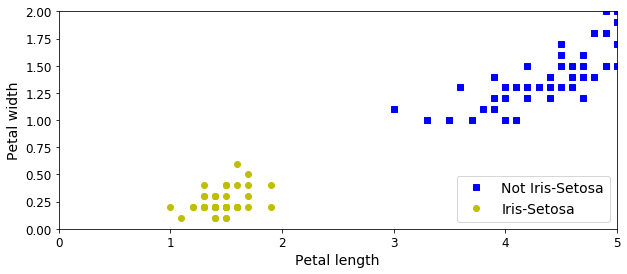

In [2]:
from sklearn.datasets import load_iris

# get dataset
iris = load_iris()
X = iris.data[:, (2, 3)]  # use only petal length and petal width
y = (iris.target == 0).astype(np.int) # classify them as either setosa or not setosa

# visualise the data
axes = [0, 5, 0, 2]
plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)
plt.show()

Clearly, this task can be easily done by using a linear classifier. Could you visualise the linear decision boundary on the figure above? Where should it be?

Now, let's move on to implementing a perceptron by using Scikit-learn.

In [3]:
from sklearn.linear_model import Perceptron

# initialise and train a perceptron
pct = Perceptron(max_iter=100, random_state=None)
pct.fit(X, y)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=100, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=None, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

Notice that there are many parameters that you can tweak later on. You can have a look at the description of each parameter in the Scikit-Learn's documentation <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html">http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html</a>

Next, we will extract the decision boundary from the model. Below we show a general way of extracting a decision boundary with any model. Note that it can be very computationally expensive if the feature space is large.

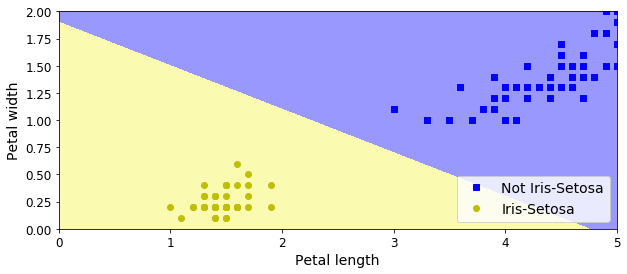

In [4]:
# sampling and predict the whole space of features
x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 10).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 10).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = pct.predict(X_new)
zz = y_predict.reshape(x0.shape)

# plot the datapoints again
plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

# get a nice color
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

# plot the predicted samples of feature space
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)
plt.show()

**_Exercise 1_**
1. The decision boundary of a single perceptron is a single straight line, but the above plot shows differently! Fix this plot. (_Hint_: you need to sample the feature space more)

   *Solution*: Change the parameter of np.linspace above to generate more points. Have a look at the documentation: https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html.

2. Try running the code in [3] and [4] multiple times; two snippets above where a network is initialised, trained, and plotted. Do you always get the same decision boundary? Why?

   *Solution*: No, it's not the same boundary because we are using Stochastic Gradient Descent to train the perceptron and the random seed is also not fixed.

3. A single perceptron is not different from a linear classifier, which can be described by a straight line equation. Retrieve the formula for it. Verify that this is correct by comparing it with the plot above. (_Hint_: have a look in the list of attribute on the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html">online documentation</a>)

   *Solution*: Basically, a perceptron multiplies each feature with weight (some value), sum them up including the bias (or the intercept), then passes to heaviside function (as specified below). Therefore, the formula can be defined accordingly as a sum of weighted inputs plus bias equating to zero. Now, you need to recover the weights from the trained perceptron; coef_ and intercept_. Then with linear algebra, you will get a straight line equation that you need to confirm with your plot.

## Activation Functions

There are many activation functions that can be used in a perceptron. Different functions result in different behaviours, and consequently different pros & cons. Though we will not go into details, it is beneficial for you to know some popular activation functions.

$$ \text{heaviside} (z) = \begin{cases} 1 & \quad \text{if } z >= 0 \\ 0 & \quad \text{otherwise} \end{cases} $$

$$ \text{logit} (z) = \frac{1}{1 + e^{-z}} $$

$$ \text{relu} (z) = \max{\left( 0 , z \right)} $$

$$ \text{leaky_relu} (z, \alpha) = \max{\left( \alpha z , z \right)} $$

$$ \text{elu} (z, \alpha) = \begin{cases} \alpha \left( e^z - 1 \right) & \quad \text{if } z < 0 \\ z & \quad \text{otherwise} \end{cases} $$

**_Exercise 2_** 
Complete the cell below with the code for the activation functions listed (see equations). Note that they must be able to process NumPy arrays as well.

In [5]:
def heaviside(z): 
    return (z >= 0).astype(z.dtype)

def logit(z): 
    return 1 / (1 + np.exp(-z))

def relu(z): 
    return np.maximum(0, z)

def leaky_relu(z, alpha=0.01): 
    return np.maximum(alpha*z, z)

def elu(z, alpha=1): 
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, 
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

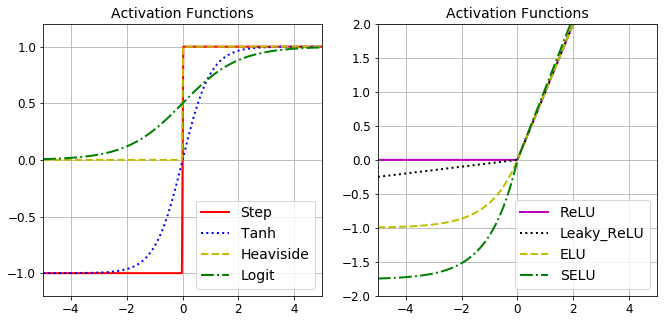

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,11))

plt.subplot(221)
plt.plot(z, np.sign(z), "r-", linewidth=2, label="Step")
plt.plot(z, np.tanh(z), "b:", linewidth=2, label="Tanh")
plt.plot(z, heaviside(z), "y--", linewidth=2, label="Heaviside")
plt.plot(z, logit(z), "g-.", linewidth=2, label="Logit")
plt.grid(True)
plt.legend(loc="lower right", fontsize=14)
plt.title("Activation Functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(222)
plt.plot(z, relu(z), "m-", linewidth=2, label="ReLU")
plt.plot(z, leaky_relu(z, 0.05), "k:", linewidth=2, label="Leaky_ReLU")
plt.plot(z, elu(z), "y--", linewidth=2, label="ELU")
plt.plot(z, selu(z), "g-.", linewidth=2, label="SELU")
plt.grid(True)
plt.legend(loc="lower right", fontsize=14)
plt.title("Activation Functions", fontsize=14)
plt.axis([-5, 5, -2, 2])

plt.show()

You should be able to see the following characteristics from the graph:
- Step function and Heaviside function are quite similar except for their output ranges.
- Similarly, the hyperbolic tangent and the logit/sigmoidal function are nearly the same except for their output ranges.
- Lastly, all variants of ReLU functions behave differently only when the input sum of a perceptron is lower than zero.

Note that different functions have different sensitivity to the perceptron input.

## Multi-Layer Perceptron (MLP) with Scikit-Learn

In this section, we introduce how to implement multilayer perceptron (MLP) with Scikit-learn. Note that Scikit-learn's MLP is not suitable for very large neural networks.

In [7]:
from sklearn.datasets import load_iris

# get dataset if you haven't
iris = load_iris()
X = iris.data[:, (2, 3)]  # use only petal length and petal width
y = (iris.target == 0).astype(np.int) # classify them as either setosa or not setosa

In [8]:
from sklearn.neural_network import MLPClassifier

# Initialise a multi-layer perceptron
mlp = MLPClassifier(max_iter=1, learning_rate_init=0.01, random_state=None, warm_start=True)
mlp

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.01, max_iter=1, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=True)

Note the MLP's parameters that you can play with. For a description of each parameter, have a look at the online documentation: <a href="http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html">http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html.</a>

Now, we will show what the decision boundary looks like and how it changes after each training epoch. _(Note that you must generate a new MLP every time before you run the code below)_

C:\Local\anaconda3\envs\MLTech\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


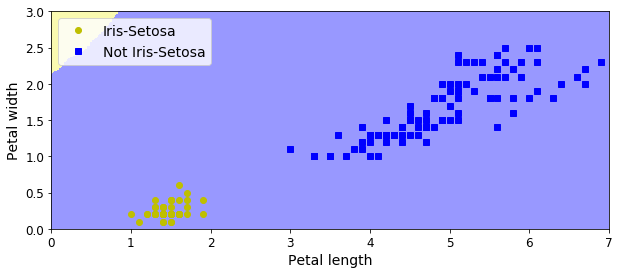

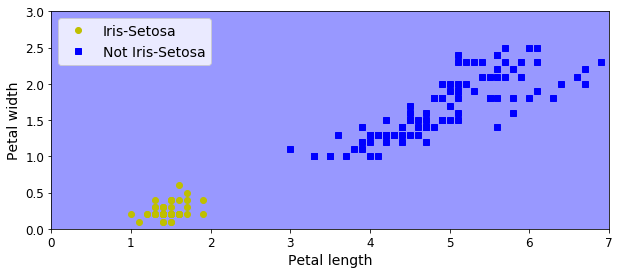

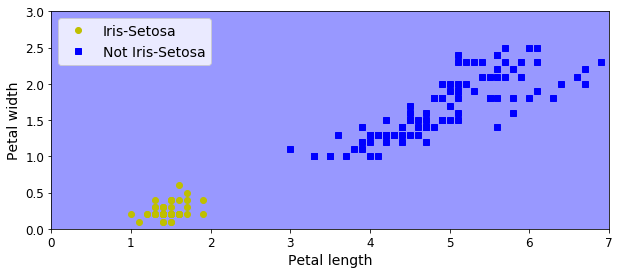

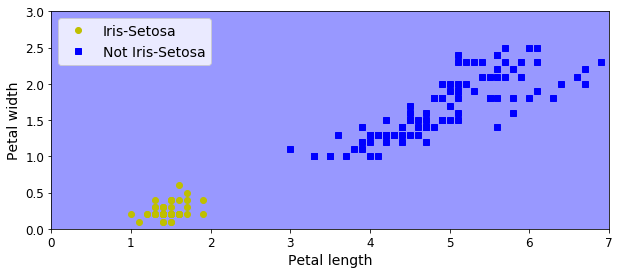

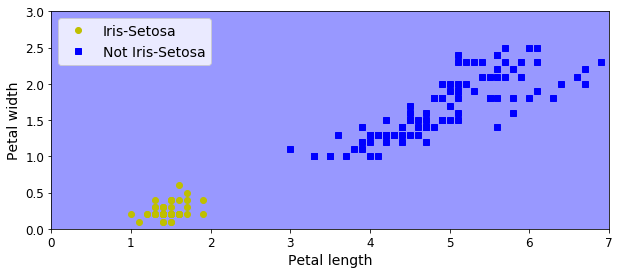

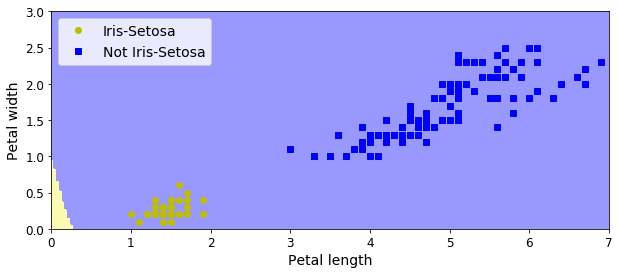

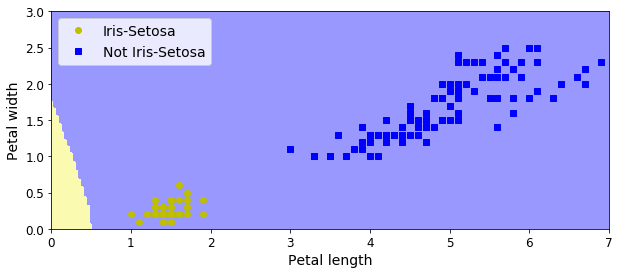

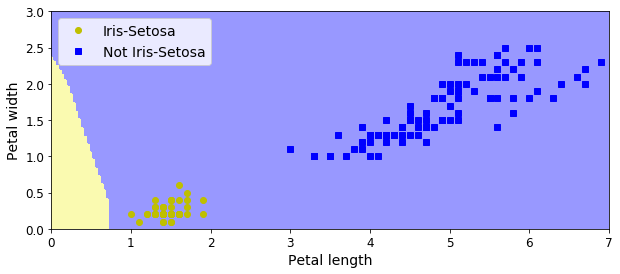

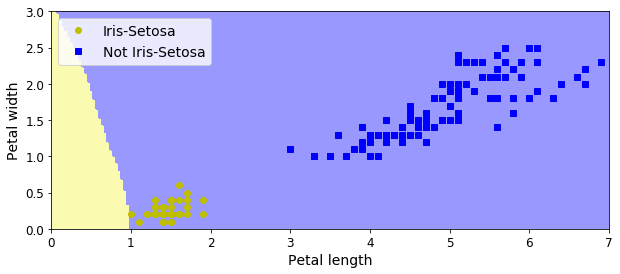

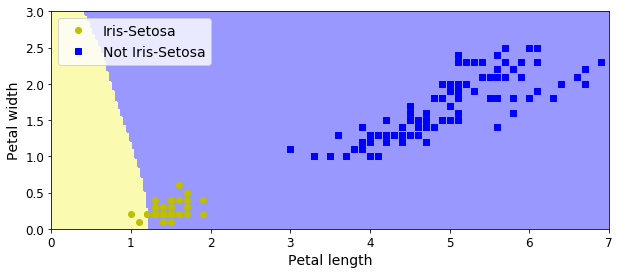

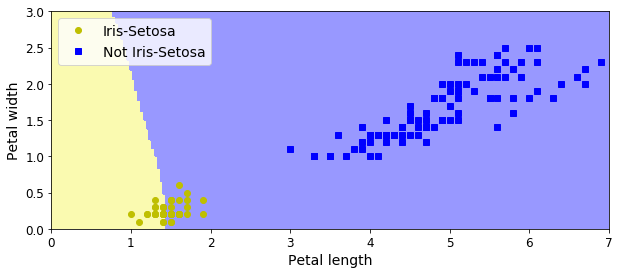

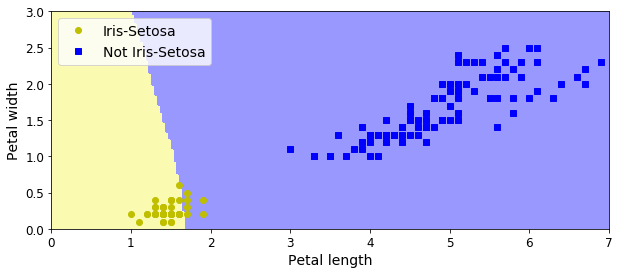

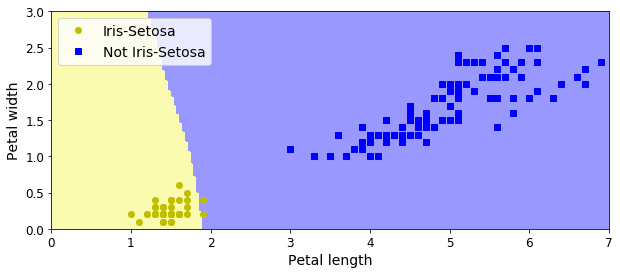

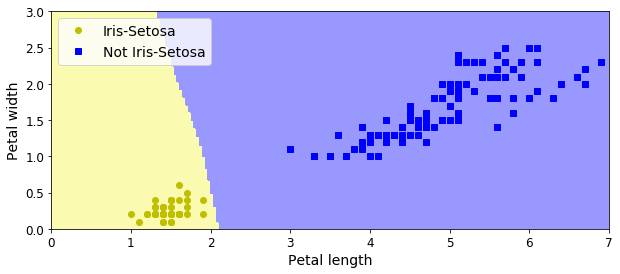

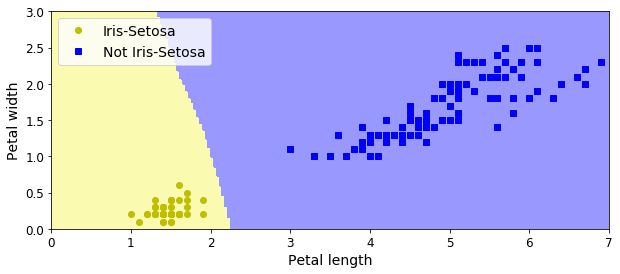

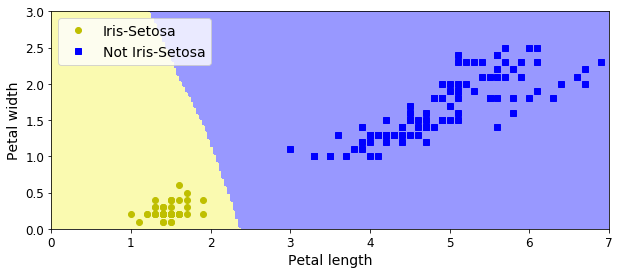

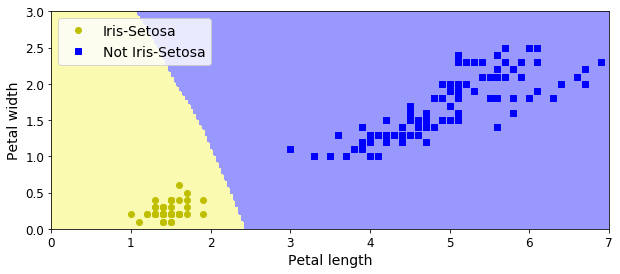

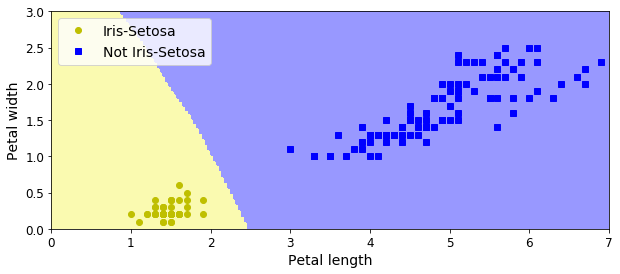

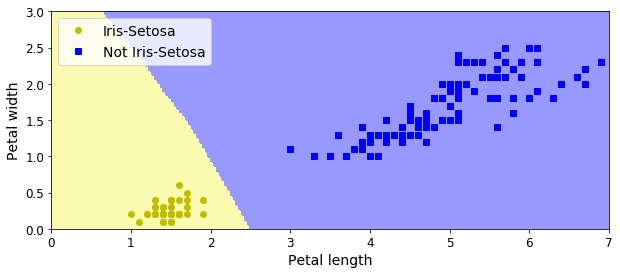

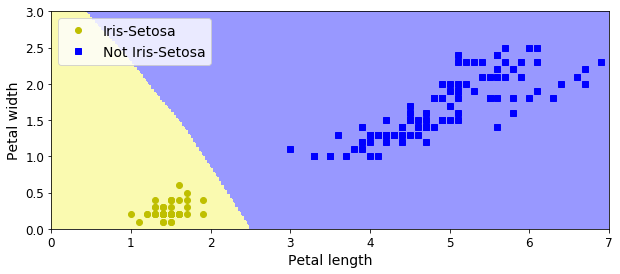

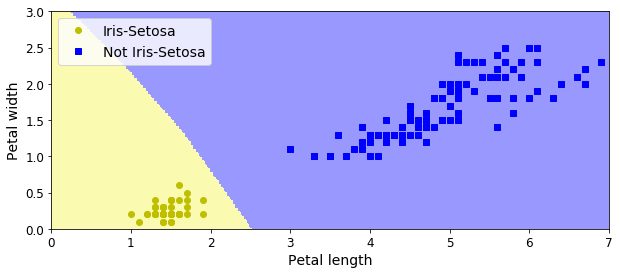

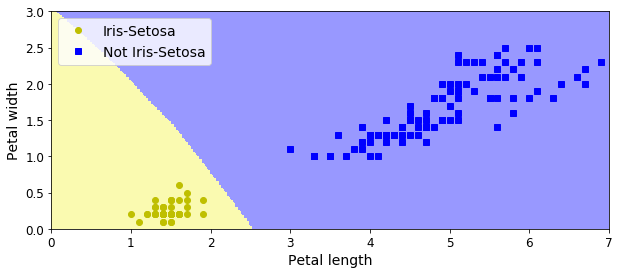

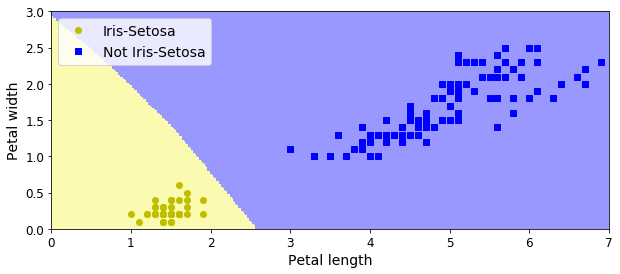

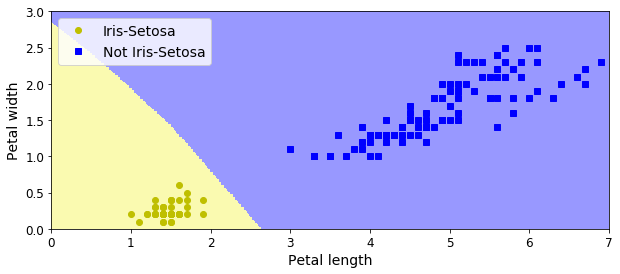

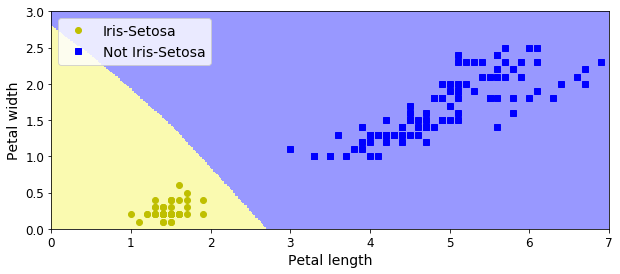

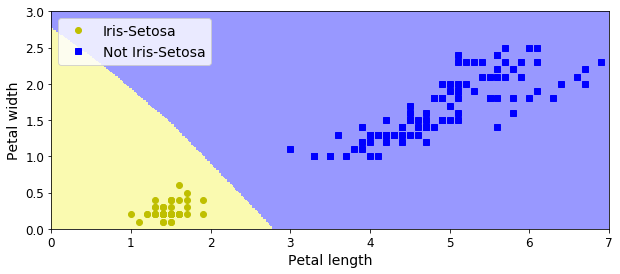

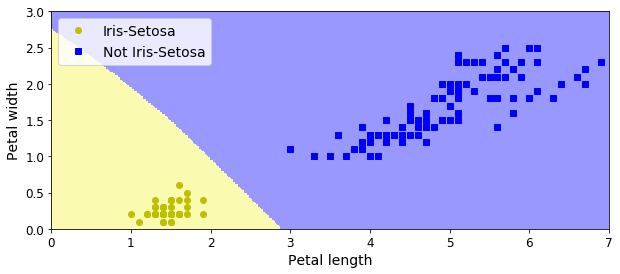

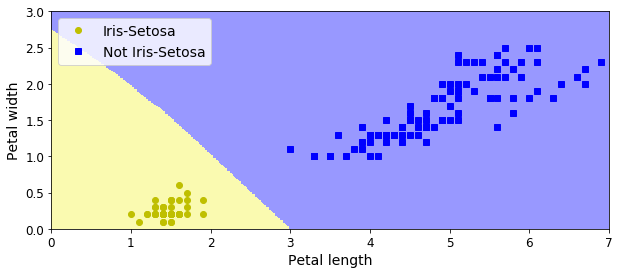

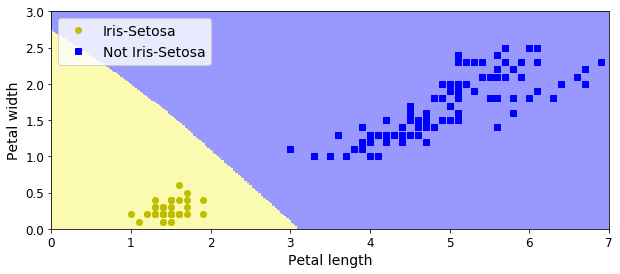

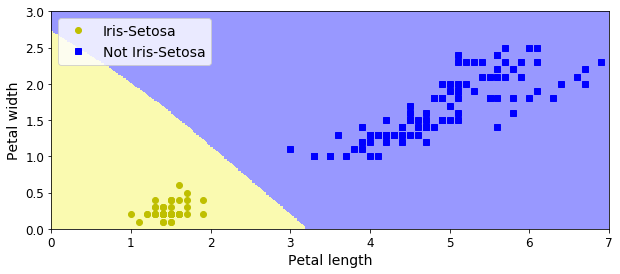

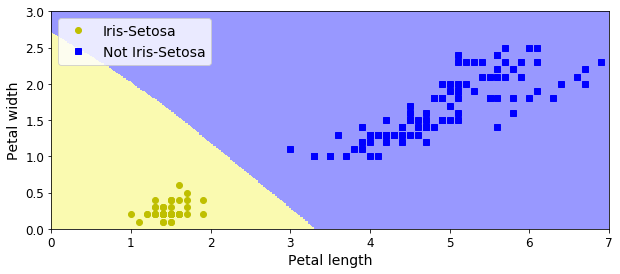

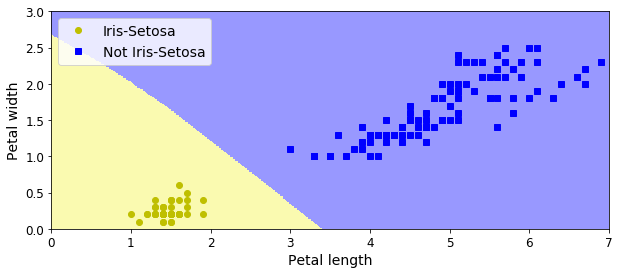

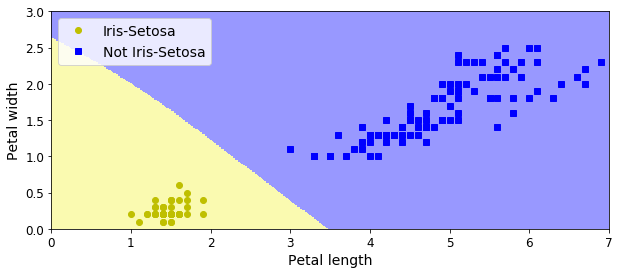

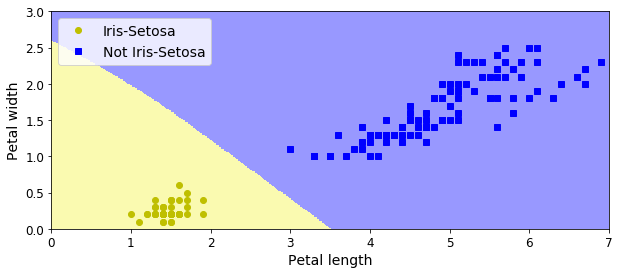

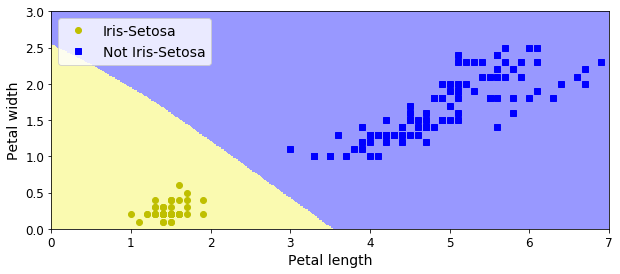

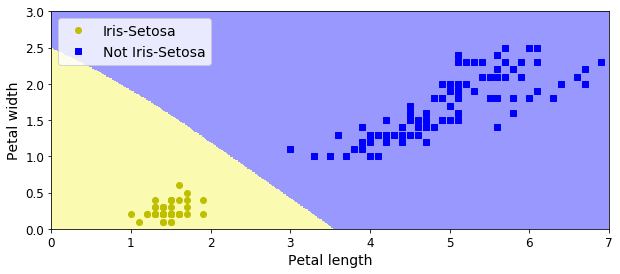

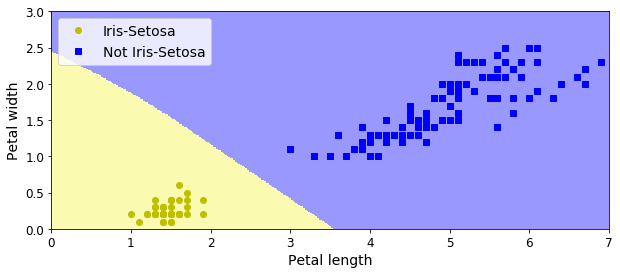

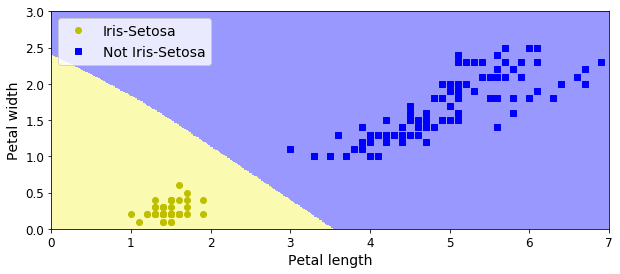

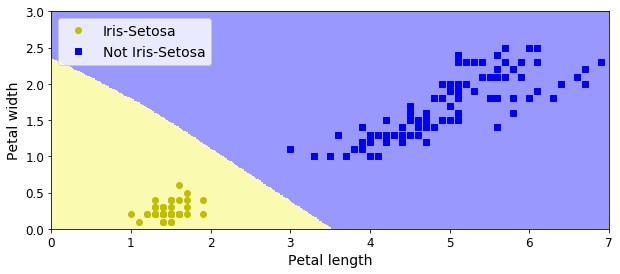

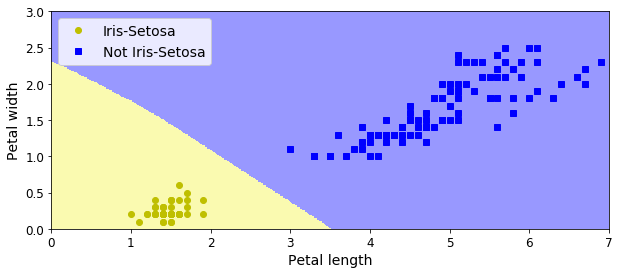

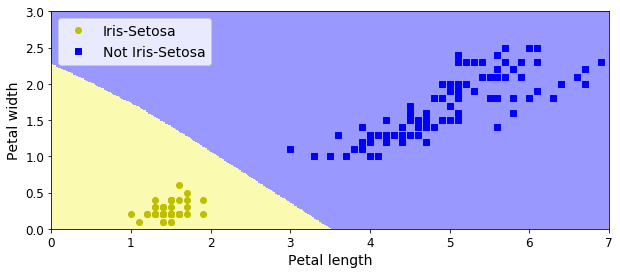

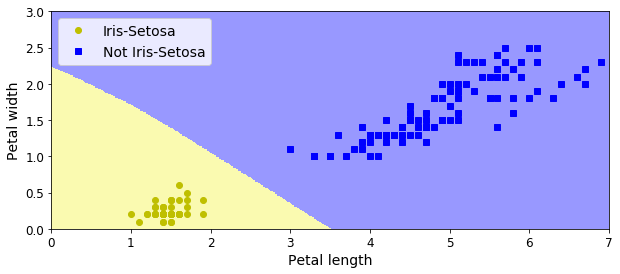

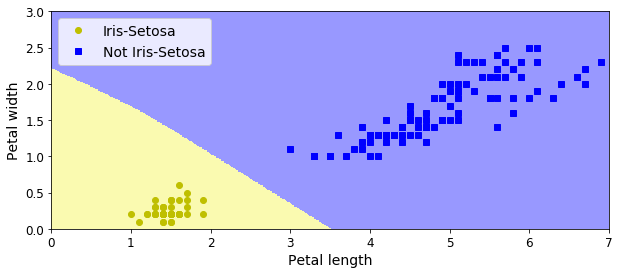

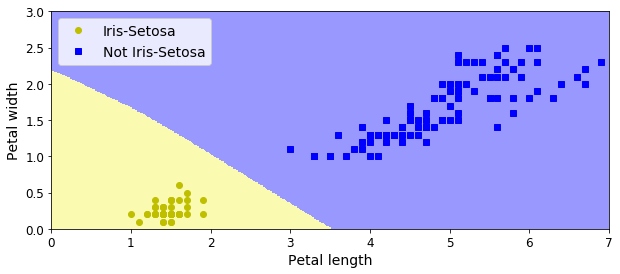

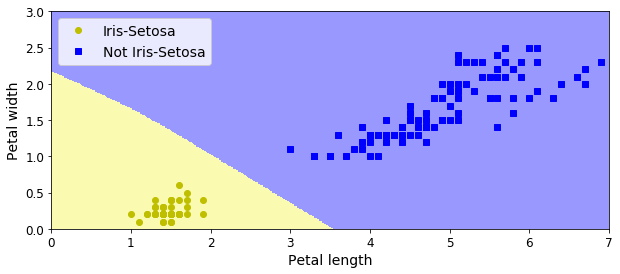

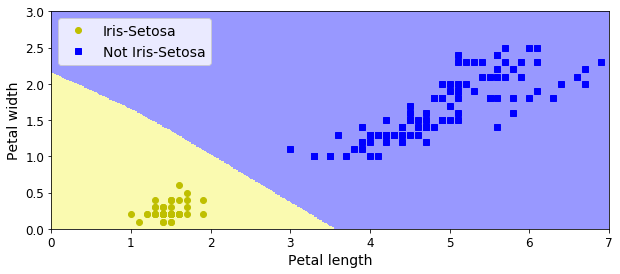

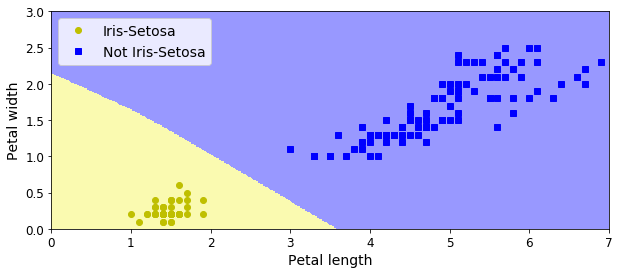

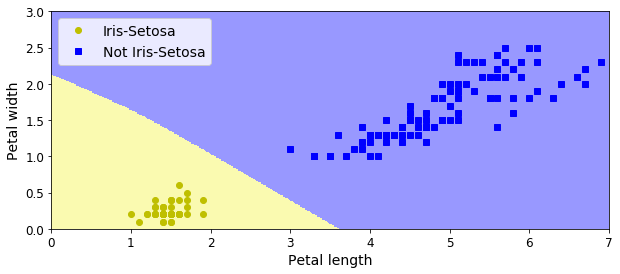

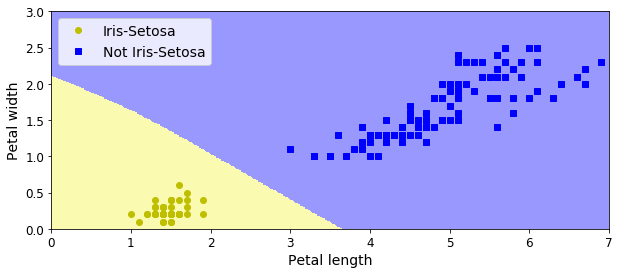

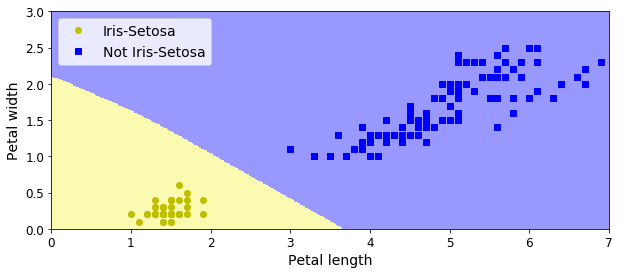

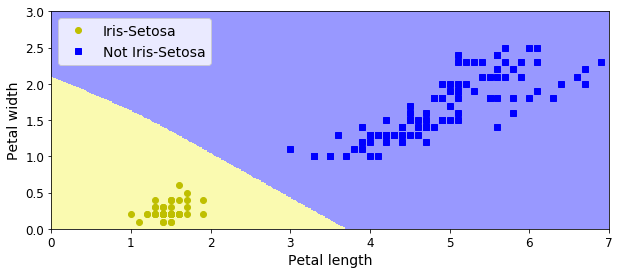

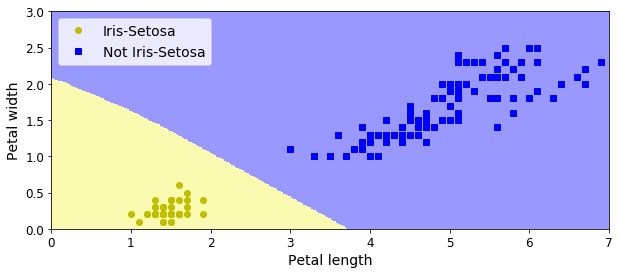

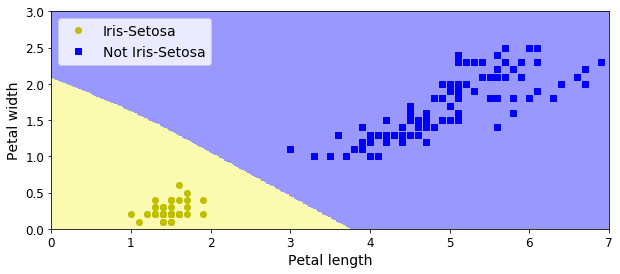

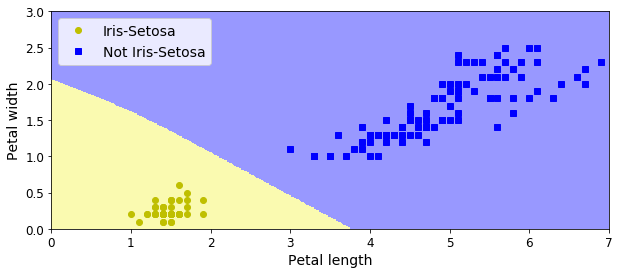

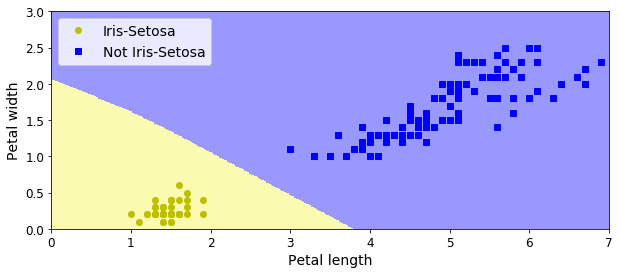

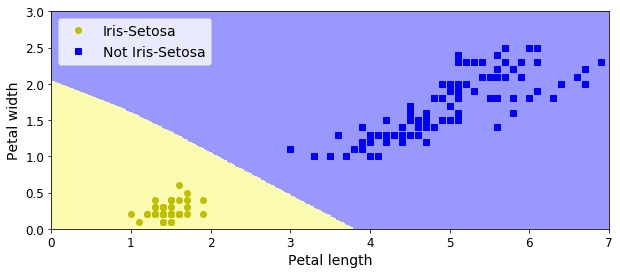

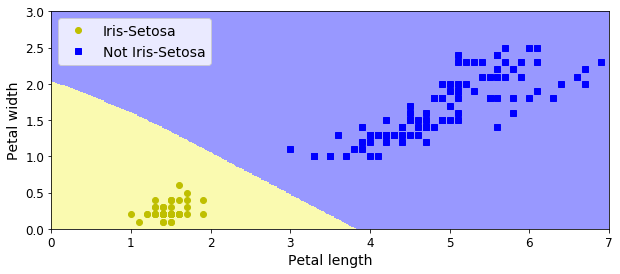

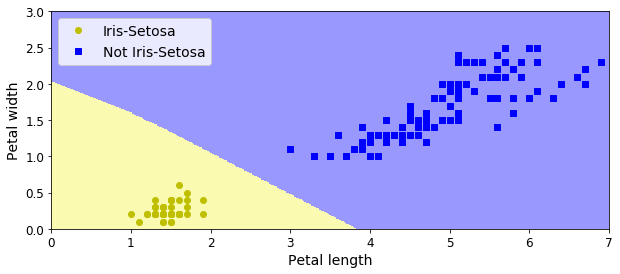

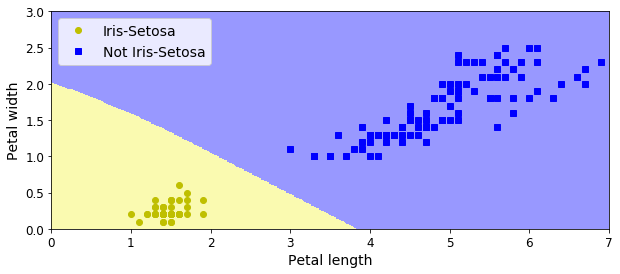

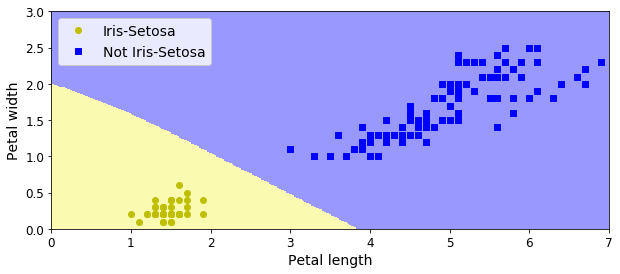

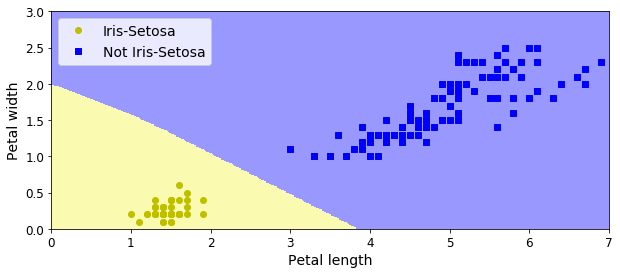

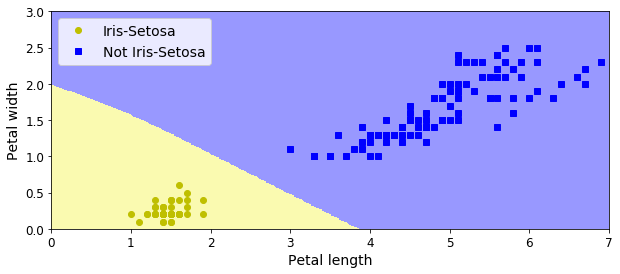

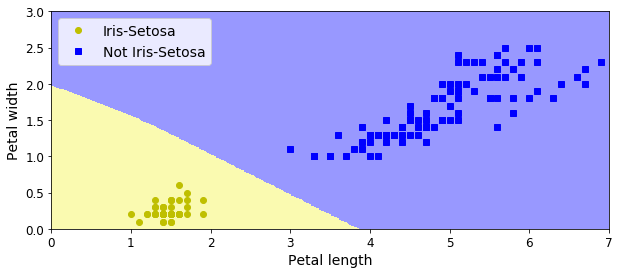

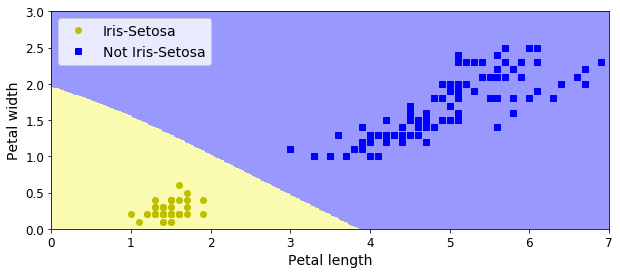

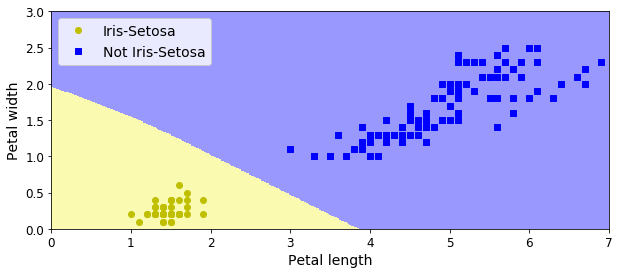

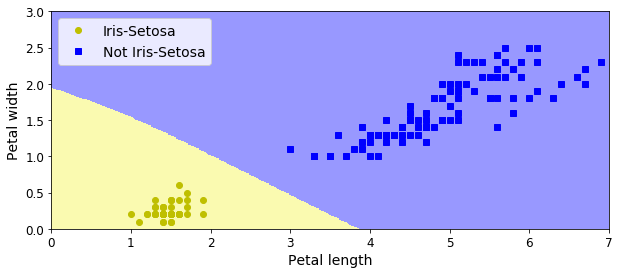

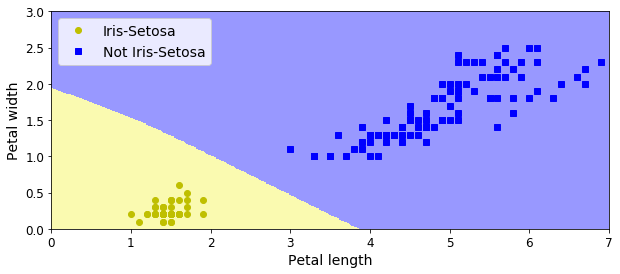

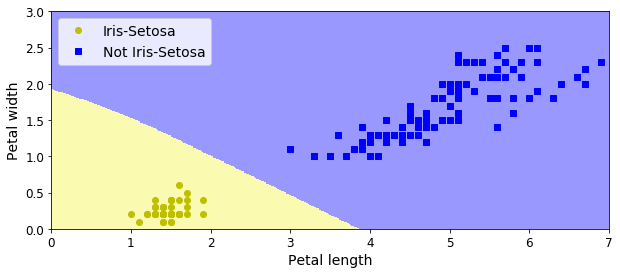

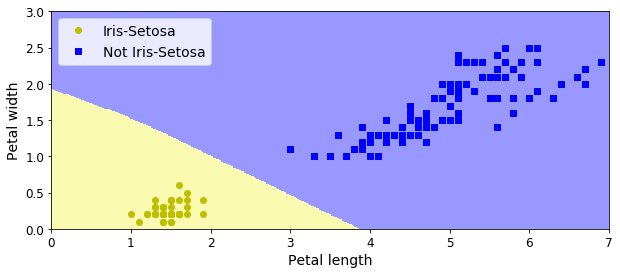

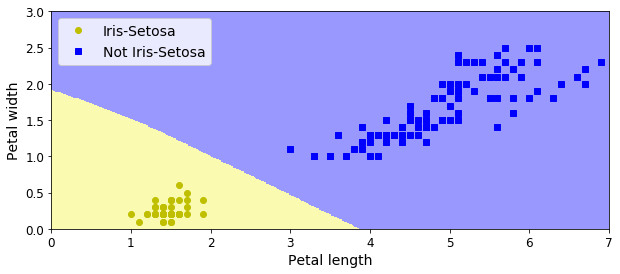

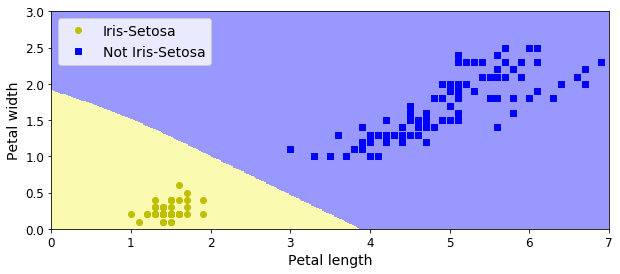

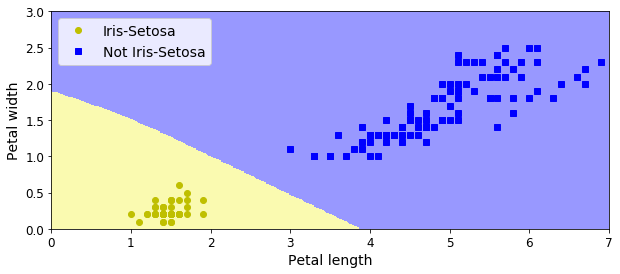

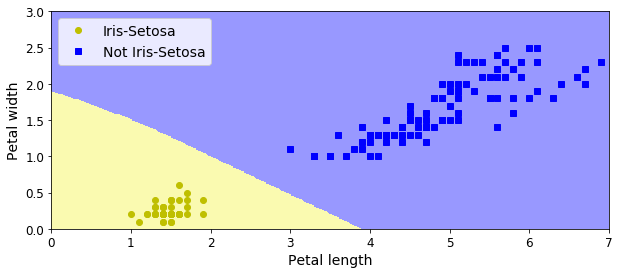

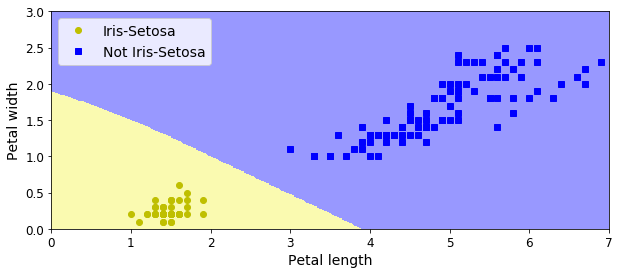

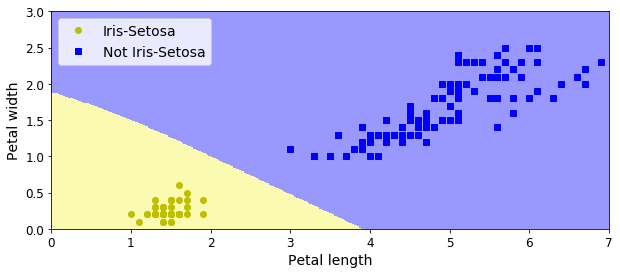

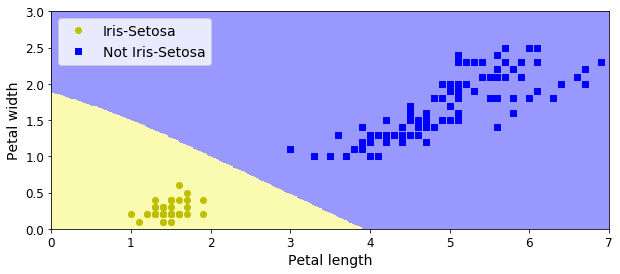

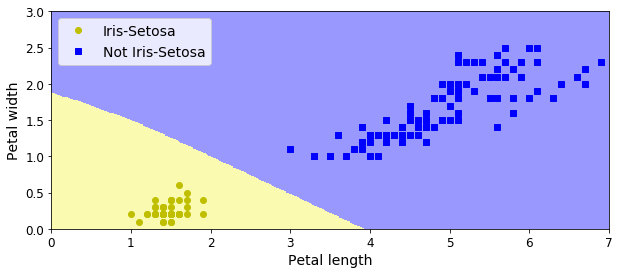

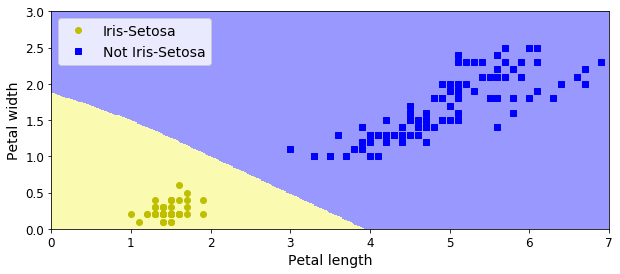

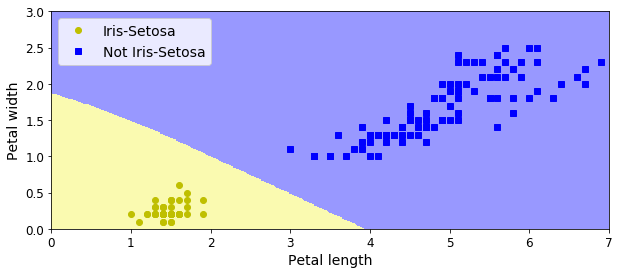

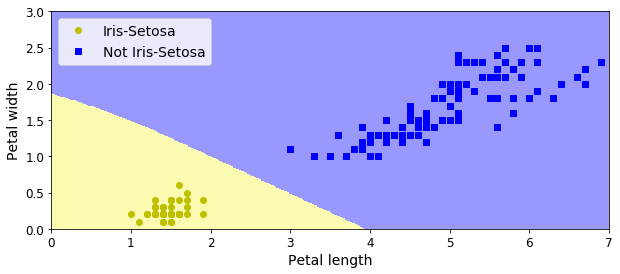

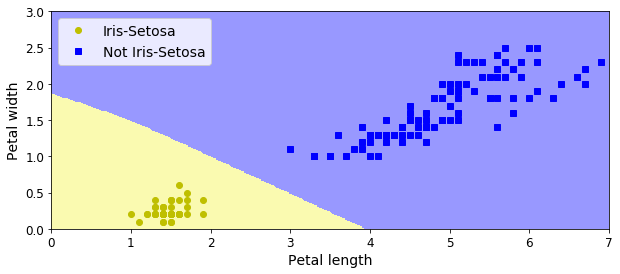

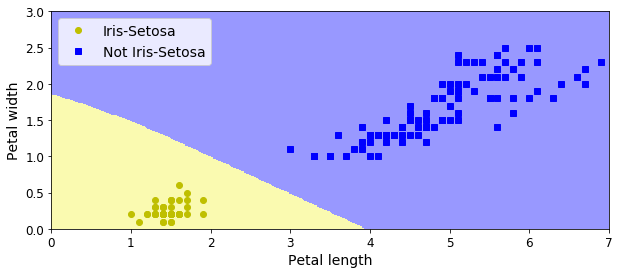

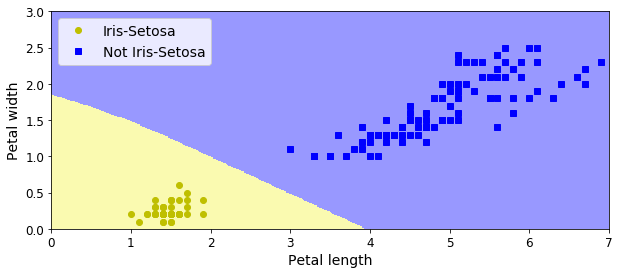

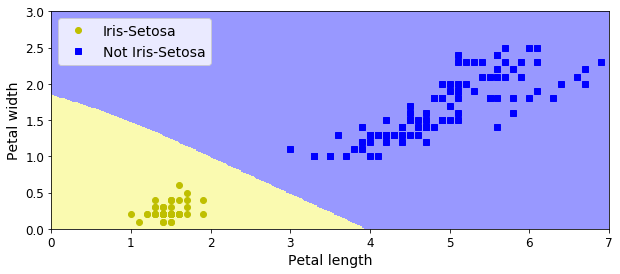

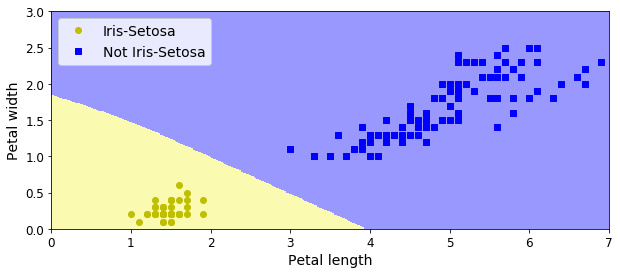

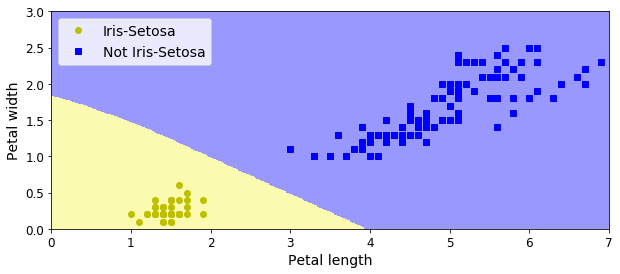

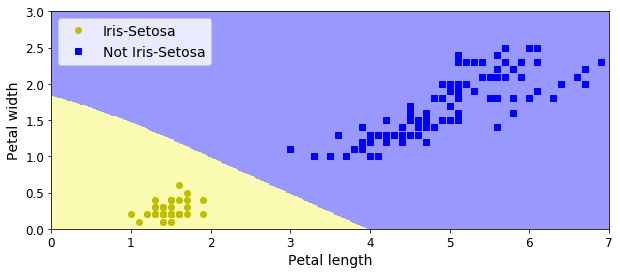

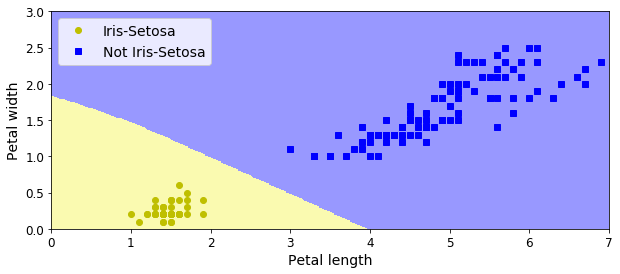

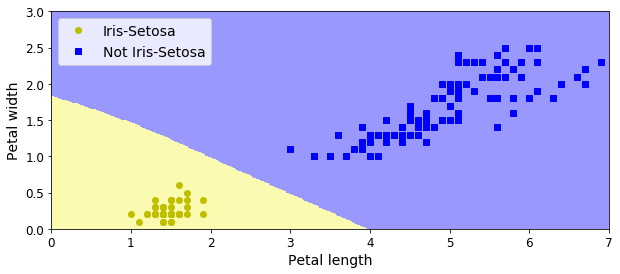

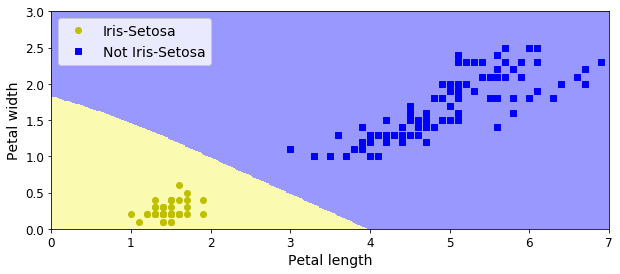

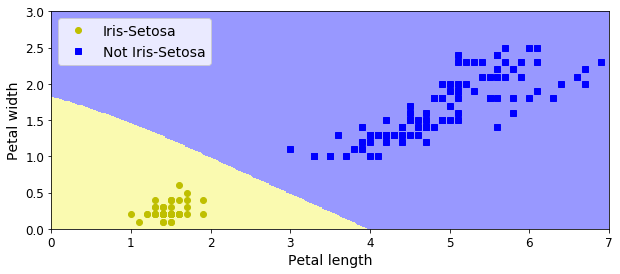

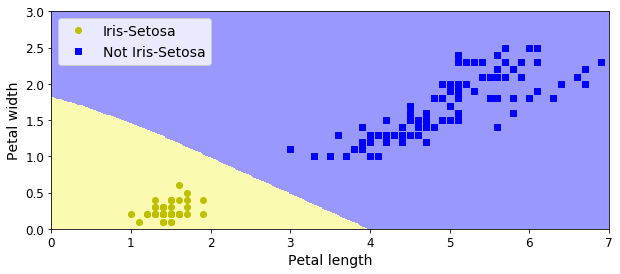

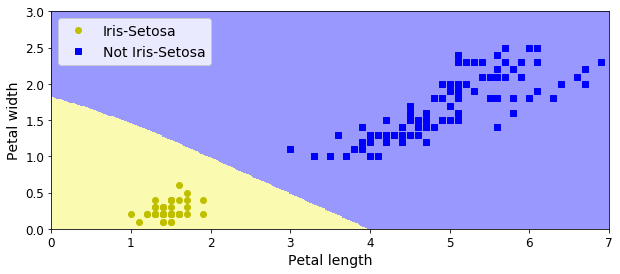

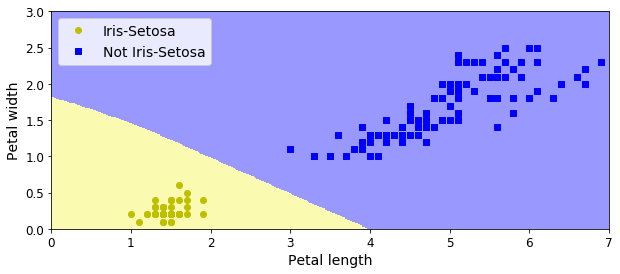

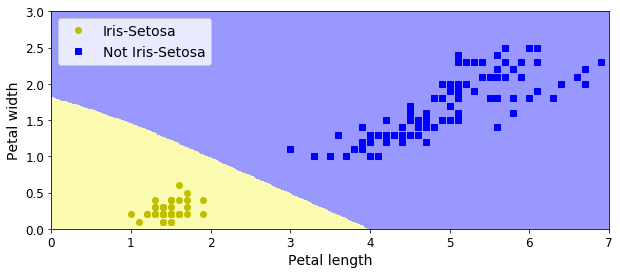

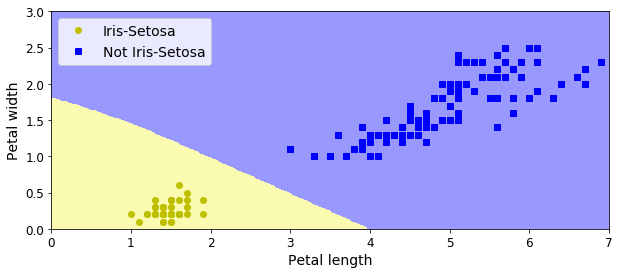

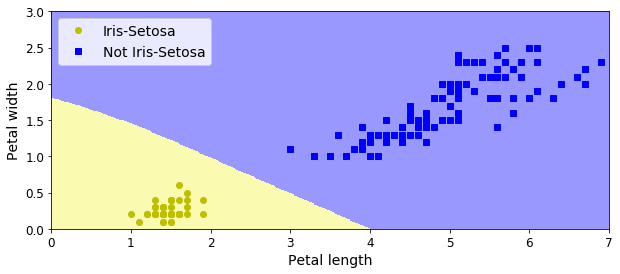

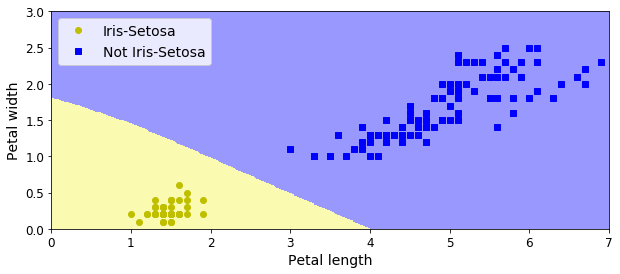

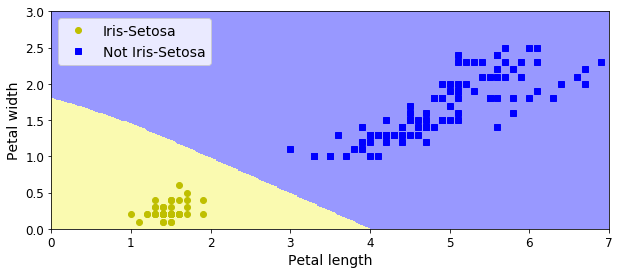

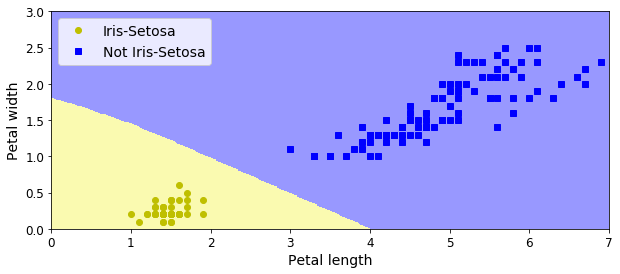

In [9]:
# Pre-define the axes for plotting
axes = [0, 7, 0, 3]

# Pre-generate a grid of sampling points
x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 200).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )

# Now, show the change after fitting epoch by epoch
for epochs in range(0,100):
    
    # Fit the model
    mlp.fit(X, y)
    
    # Plot the dataset
    plt.figure(figsize=(10, 4))
    plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")
    plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
    
    # Use to model to sampling predictions over all feature space
    y_predict = mlp.predict(np.c_[x0.ravel(), x1.ravel()])
    zz = y_predict.reshape(x0.shape)
    
    # get a nice color
    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#9898ff', '#fafab0'])
    
    # Use contour plot again
    plt.contourf(x0, x1, zz, cmap=custom_cmap)
    plt.xlabel("Petal length", fontsize=14)
    plt.ylabel("Petal width", fontsize=14)
    plt.legend(loc="upper left", fontsize=14)
    plt.axis(axes)
    plt.show()

**_Exercise 3_**
1. What is the structure of this MLP? How many neurons in each layer?

   *Solution*: Since we didn't change the number of neurons in hidden layer, this MLP has 2, 100 and 1 neurons in its input layer, its hidden layer and its output layer respectively.

2. Try different numbers of neurons in the hidden layer. Observe any difference during and after the training.

   *Solution*: Specifying number in parameter 'hidden_layer_sizes' changes number of neurons in the hidden layer. Now, since these two categories can be linearly separated, this task is easy and can be done by a perceptron as shown earlier. Therefore, an MLP with one neuron in its hidden layer can still be used to fit these data.

3. Try different activation functions such as logistic or hyperbolic tangent function. Observe any difference in the resulting plot.

   *Solution*: Specifying function name in parameter 'activation' changes activation function of the hidden layer. Currently there are 4 built-in functions: *identity*, *logistic*, *tanh*, and *relu*. Since this task is easy, there is no significant difference of using different functions here. However, activation functions such as logistic and tanh should yield a training time comparably lower when you are using a very deep neural network.

4. Try a stochastic gradient descent optimiser, and configure the learning rate and momentum accordingly. Observe any difference during and after the training.

   *Solution*: Specifying optimiser by changing parameter *solver*. Similarly, learning rate and momentum can be configured by changing parameter *learning_rate* and *momentum* respectively. In a case where you use constant learning rate with large momentum value, your MLP's training error might not converge to a local optimum. Usually, it is therefore common to train MLP with a large number of epochs with either a small constant learning rate or a large adaptive learning rate that will decrease in each epoch.

(_Hint_: Refer to the online documentation on <a href="http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html">http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html</a>)

## (Deeper) Neural Net for MNIST on TensorFlow

In this section, we will construct and train a _deeper_ neural network with TensorFlow to perform classification. To train a large number of neurons, we would generally need a large dataset. So we will use MNIST from now on. Though it is not a good practice, we will use the whole dataset to train our neural net (for demonstration purposes).

In [10]:
# Load and use all digits in MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
digits = np.concatenate((X_train, X_test))
labels = np.concatenate((y_train, y_test))

# Pre-processing the data
t_digits = digits.astype(np.float32).reshape(-1, 28*28) / 255.0
t_labels = labels.astype(np.int32)

Next, we will define a function to construct a layer of fully-connected neurons. This is more convenient than individually creating each neuron or perceptron.

In [11]:
n_inputs = 28*28  # Total number of pixels in each MNIST's digit
n_hidden1 = 300 # Number of neurons in 1st hidden layer
n_hidden2 = 100 # Number of neurons in 2nd hidden layer
n_outputs = 10 # Number of neurons in output layer

reset_graph() # as we defined in the beginning of this notebook

# Create TensorFlow's placeholders for t_digits and t_labels
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

# Define a function to create a layer of fully-connected neurons
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

We then use this function to generate a layer of neurons that connect to either the input or the previous layer.

In [12]:
# Construct MLP with two layers
hidden1 = neuron_layer(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
logits = neuron_layer(hidden2, n_outputs, name="outputs")

# Or decomment below to use TensorFlow's premade instead of our function
#hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
#hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
#logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

To train this network, we need to define a loss function and choose an optimiser. After everything is constructed in TensorFlow, we run a session to execute it as usual. The code below also demonstrates how to save and restore the trained model for later use.

In [13]:
# Use mean softmax cross entropy as a loss function
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

# Use gradient descent to train MLP
training_op = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

# Define accuracy measure
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# Initilise and run TensorFlow's computation graph of MLP
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(50):
        sess.run(training_op, feed_dict={X: t_digits, y: t_labels})
        acc_batch = accuracy.eval(feed_dict={X: t_digits, y: t_labels})
        print(epoch, "Accuracy:", acc_batch)
    
    # save the trained model
    save_path = tf.train.Saver().save(sess, "./trained_mnist_ann.ckpt")

0 Accuracy: 0.09788571
1 Accuracy: 0.09794286
2 Accuracy: 0.097985715
3 Accuracy: 0.09817143
4 Accuracy: 0.09821428
5 Accuracy: 0.09837143
6 Accuracy: 0.098142855
7 Accuracy: 0.09845714
8 Accuracy: 0.09835714
9 Accuracy: 0.098642856
10 Accuracy: 0.09878571
11 Accuracy: 0.09882857
12 Accuracy: 0.09891429
13 Accuracy: 0.09925714
14 Accuracy: 0.09947143
15 Accuracy: 0.0999
16 Accuracy: 0.10008571
17 Accuracy: 0.100342855
18 Accuracy: 0.100842856
19 Accuracy: 0.10117143
20 Accuracy: 0.10168572
21 Accuracy: 0.102314286
22 Accuracy: 0.103114285
23 Accuracy: 0.103685714
24 Accuracy: 0.10412857
25 Accuracy: 0.10502857
26 Accuracy: 0.10552857
27 Accuracy: 0.106214285
28 Accuracy: 0.106557146
29 Accuracy: 0.1073
30 Accuracy: 0.1082
31 Accuracy: 0.10852857
32 Accuracy: 0.10892857
33 Accuracy: 0.1097
34 Accuracy: 0.11071429
35 Accuracy: 0.1115
36 Accuracy: 0.11237143
37 Accuracy: 0.11384286
38 Accuracy: 0.11464286
39 Accuracy: 0.11595714
40 Accuracy: 0.11702857
41 Accuracy: 0.1177
42 Accuracy: 0.1

INFO:tensorflow:Restoring parameters from ./trained_mnist_ann.ckpt
Predicted class:  [8]
Actual class:  4


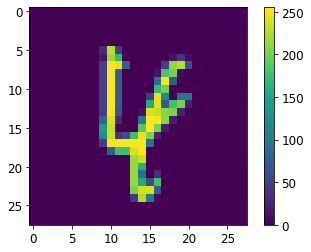

In [14]:
# random one digit
rnd_id = np.random.randint(0, len(digits))

# show the digit
plt.figure()
plt.imshow(digits[rnd_id])
plt.colorbar()
plt.grid(False)

# load the trained model and use to predict
with tf.Session() as sess:
    tf.train.Saver().restore(sess, "./trained_mnist_ann.ckpt")
    Z = logits.eval(feed_dict={X: t_digits[rnd_id].reshape(1, 28*28)})
    y_pred = np.argmax(Z, axis=1)
print("Predicted class: ", y_pred)
print("Actual class: ", labels[rnd_id])

Rerun the cell above multiple times to see how accurate our trained model is. You should be able to see that the resulted accuracy is very low and our training is slightly time-consuming.

**_Exercise 4_**
Modify and tune the neural net such that the training time is reduced but the accuracy is still acceptably high. You should try the following:
- Change the structure of the network by adding/removing a hidden layer or increasing/reducing number of neurons.

   *Solution*: You can change the structure when we used function neuron_layer above.

- Change the activation function of the hidden layers.

   *Solution*: Similarly, the activation function can be changed in function neuron_layer.

- Choose different optimisation algorithms such as tf.train.MomentumOptimizer(), tf.train.RMSPropOptimizer, and tf.train.AdamOptimizer(). Don't forget to change the training parameters accordingly.

   *Solution*: This can be changed when we defined training_op above. Details about these optimisation algorithms can be looked on https://www.tensorflow.org/api_docs/python/tf/train.

Do you observe any effect on the accuracy during the tuning? What is the best model that you can achieve?

## Convolutional Neural Network (CNN) with TensorFlow

We now move on to convolutional neural net (CNN). The idea behind this architecture originated from a study on the animal visual cortex.

In [15]:
# Load and use all digits in MNIST if you have directly jumped to this section
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
digits = np.concatenate((X_train, X_test))
labels = np.concatenate((y_train, y_test))

# Pre-processing the data
t_digits = digits.astype(np.float32).reshape(-1, 28*28) / 255.0
t_labels = labels.astype(np.int32)

# MNIST's specification
height = 28
width = 28
channels = 1

As usual, we begin with creating TensorFlow computation graph, a loss function, and an optimiser for training the CNN.

In [16]:
reset_graph() # as we defined in the beginning of this notebook

# Create TensorFlow's placeholders for digits and labels
X = tf.placeholder(tf.float32, shape=[None, height * width], name="X")
X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
y = tf.placeholder(tf.int32, shape=[None], name="y")

# Construct 2D convolutional layers
conv1 = tf.layers.conv2d(X_reshaped, filters=20, kernel_size=3, strides=1, 
                         padding="SAME", activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=40, kernel_size=3, strides=2, 
                         padding="SAME", activation=tf.nn.relu, name="conv2")

# Create a max pooling layer
pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
pool3_flat = tf.reshape(pool3, shape=[-1, 40 * 7 * 7])

# Followed by layer of fully-connected neurons
fc1 = tf.layers.dense(pool3_flat, 50, activation=tf.nn.relu, name="fc1")
logits = tf.layers.dense(fc1, 10, name="output")

# Use mean softmax cross entropy as a loss function
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(xentropy)

# Use Adam Optimiser to train CNN 
training_op = tf.train.AdamOptimizer().minimize(loss, 
                                                aggregation_method=tf.AggregationMethod.EXPERIMENTAL_ACCUMULATE_N)
# (Change the aggregation_method to tf.AggregationMethod.EXPERIMENTAL_TREE or DEFAULT if it doesn't work)

# Define accuracy measure
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.


Then, we proceed to executing the TensorFlow computation graph, which will train our CNN.

<font color="red">**_Note that training a CNN is generally time- and memory-consuming. It is very likely that your PC will either be slow down or frozen. If this is the case, click the stop button above, wait for a couple of minutes, restart your Python kernel, and jump down to the exercise below._**</font>

In [17]:
# Define a function to make training batches
# This is useful when your PC doesn't have much memory
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

# Train the CNN batch by batch
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(10):
        for X_batch, y_batch in shuffle_batch(t_digits, t_labels, 50): 
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: t_digits, y: t_labels})
        print(epoch, "Accuracy:", acc_batch)
    
    # save the trained model
    save_path = tf.train.Saver().save(sess, "./trained_mnist_cnn.ckpt")

0 Accuracy: 0.9807714
1 Accuracy: 0.9882857
2 Accuracy: 0.9898857
3 Accuracy: 0.9941857
4 Accuracy: 0.9963857
5 Accuracy: 0.99564284
6 Accuracy: 0.99652857
7 Accuracy: 0.9964
8 Accuracy: 0.99808574
9 Accuracy: 0.9983571


INFO:tensorflow:Restoring parameters from ./trained_mnist_cnn.ckpt
Predicted class:  [2]
Actual class:  2


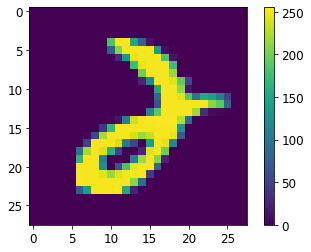

In [18]:
# random one digit for test CNN's prediction
rnd_id = np.random.randint(0, len(digits))

# visualise the digit
plt.figure()
plt.imshow(digits[rnd_id])
plt.colorbar()
plt.grid(False)

# load the trained model and use to predict
with tf.Session() as sess:
    tf.train.Saver().restore(sess, "./trained_mnist_cnn.ckpt")
    Z = logits.eval(feed_dict={X: t_digits[rnd_id].reshape(1, 28*28)})
    y_pred = np.argmax(Z, axis=1)

print("Predicted class: ", y_pred)
print("Actual class: ", labels[rnd_id])

**_Exercise 5_**
1. Visualise and/or draw on your paper this convolutional neural net to figure out its current structure.

   *Solution*: 1st convolutional neuron layer (20 filters, 3x3 receptive field, 1 stride, zero padding) -> 2nd convolutional neuron layer (40 filters, 3x3 receptive field, 2 strides, zero padding) -> max pooling layer (2x2 receptive field, 2 strides, no padding) -> fully-connected layer of 50 neurons -> output layer of 10 neurons

2. Tune the model such that the accuracy is acceptably good, the required memory is low, and the training time is small.

   *Solution*: A number of modifications can be made; e.g. removing layer, removing number of neurons, removing number of filters, increasing the size of receptive field, or increasing striding length.

## Overfitting

'With 4 parameters I can fit an elephant and with 5 I can make him wiggle his trunk.' John von Neumann, _cited by Enrico Fermi in Nature 427_

Do not forget that an overfitted model will not perform well in the real world. It is therefore important for you to know how to prevent this issue with neural networks in general.

**_Exercise 6_**
1. Recall the characteristic of overfitted models with respect to their performance on the training and test sets.

   *Solution*: An overfitted model performs very good on the training set, but very bad on the test set.

2. Restore this notebook back to its original state and then modify the code above to partition the MNIST dataset into training set and test set.

   *Solution*: Dataset above has already pre-partitioned; so just removing the concatenation of training set and test set.

3. Further modify the training phase of deep net and/or CNN to use only the training set and evaluate accuracy or loss on both datasets.

   *Solution*: Preprocess the data for both train and test set, but assign X_train and y_train to t_digit and t_labels respectively.

4. On deep net and/or CNN for MNIST above, implement one or a combination of the regularisation techniques listed below. Observe any difference or change in performance during training:

   4.1. Early stopping, where you stop training your model if there is no further significant improvement of performance on your test set. (_Hint_: regularly check the performance on both sets and always store the best model)
   
   4.2. $l_1$ or $l_2$ regularisation, by correctly specifying TensorFlow parameters. (_Hint_: Look for 'kernel_regularizer' in the online documentation)
   
   4.3. Dropout, where each neuron has a probability of being turned off at each epoch in training phase (_Hint_: apply <a href="https://www.tensorflow.org/api_docs/python/tf/layers/dropout">tf.layers.dropout()</a> to the input layer and/or any hidden layer's output, but NOT the output of the output layer)

In [19]:
# 4.1
# Reload the dataset again
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

# Define and initialise functions similar to above again
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    loss_summary = tf.summary.scalar('log_loss', loss)

learning_rate = 0.01
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    accuracy_summary = tf.summary.scalar('accuracy', accuracy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

# We will need to log performace at each interval to be able to stop training early
from datetime import datetime
def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)
logdir = log_dir("mnist_dnn")
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Now we start training
m, n = X_train.shape
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_deep_mnist_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_deep_mnist_model"

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = 50

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val, loss_val, accuracy_summary_str, loss_summary_str = sess.run([accuracy, loss, accuracy_summary, loss_summary], feed_dict={X: X_valid, y: y_valid})
        file_writer.add_summary(accuracy_summary_str, epoch)
        file_writer.add_summary(loss_summary_str, epoch)
        if epoch % 5 == 0:
            print("Epoch:", epoch,
                  "\tValidation accuracy: {:.3f}%".format(accuracy_val * 100),
                  "\tLoss: {:.5f}".format(loss_val))
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
            if loss_val < best_loss:
                saver.save(sess, final_model_path)
                best_loss = loss_val
            else:
                epochs_without_progress += 5
                if epochs_without_progress > max_epochs_without_progress:
                    print("Early stopping")
                    break

Epoch: 0 	Validation accuracy: 90.440% 	Loss: 0.35598
Epoch: 5 	Validation accuracy: 94.700% 	Loss: 0.18645
Epoch: 10 	Validation accuracy: 96.360% 	Loss: 0.13761
Epoch: 15 	Validation accuracy: 97.020% 	Loss: 0.11079
Epoch: 20 	Validation accuracy: 97.300% 	Loss: 0.09601
Epoch: 25 	Validation accuracy: 97.480% 	Loss: 0.08491
Epoch: 30 	Validation accuracy: 97.760% 	Loss: 0.07870
Epoch: 35 	Validation accuracy: 97.920% 	Loss: 0.07450
Epoch: 40 	Validation accuracy: 97.860% 	Loss: 0.07273
Epoch: 45 	Validation accuracy: 97.980% 	Loss: 0.06970
Epoch: 50 	Validation accuracy: 97.940% 	Loss: 0.06884
Epoch: 55 	Validation accuracy: 98.140% 	Loss: 0.06880
Epoch: 60 	Validation accuracy: 98.120% 	Loss: 0.06769
Epoch: 65 	Validation accuracy: 98.140% 	Loss: 0.06763
Epoch: 70 	Validation accuracy: 98.120% 	Loss: 0.06742
Epoch: 75 	Validation accuracy: 98.200% 	Loss: 0.06665
Epoch: 80 	Validation accuracy: 98.220% 	Loss: 0.06742
Epoch: 85 	Validation accuracy: 98.280% 	Loss: 0.06840
Epoch: 90 	V

In [20]:
# 4.2
# Just specify arguments kernel_regularizer when you call tf.layers.Conv2D() or tf.layers.Dense().
# Have a look at https://keras.io/regularizers/ for 3 types of 

# Or you can modify the loss function to incorporate regularization; e.g. tf.nn.l2_loss()
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
regularizer = tf.nn.l2_loss(weights)
loss = tf.reduce_mean(xentropy + beta * regularizer)

NameError: name 'weights' is not defined

In [21]:
# 4.3
# Examples of using tf.layers.dropout()
hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name="hidden1")
hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu, name="hidden2")
hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

# It is similar to introduce another layers of network that will set input to zero sometime

NameError: name 'X_drop' is not defined

## Sidenote
There are many high level APIs that you can use to quickly create and deploy Machine Learning prototypes. They are very useful but it is difficult to make non-standard changes to their implementation of Machine Learning models. If you are interested, have a look on the following:
- Estimators: <a href="https://www.tensorflow.org/guide/estimators">https://www.tensorflow.org/guide/estimators</a>
- Keras: <a href="https://www.tensorflow.org/guide/keras">https://www.tensorflow.org/guide/keras</a>
- Eager execution: <a href="https://www.tensorflow.org/guide/eager">https://www.tensorflow.org/guide/eager</a>

## Reference
Aurélien Géron, _Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems_.